# Project notebook **<span style="COLOR:RED"></span>**


### Student 1
Name : Sebastien Moeller
<br>Group : advanced
### Student 2
Name : Viktor Malesevic
<br>Group : advanced
### Data name : 
* Poloniex Exchange data
* Google Trends
### Data URL : 
* API from https://poloniex.com/exchange and https://trends.google.fr/trends/
### Short summary of the project and datasource :
* Linking social media trends to the prices of cryptocurrencies.

### Aims : 
* The aim of the project is to see how Google Trends influence BitCoin prices
* We want to combine historical prices to historical Google Trends of terms related to BitCoin
* Give investment recommendation according to these trends. 
* What will the future price be according to trends
* Will the price increase or decrease? To which extend?

# Part 1: Data pre-processing

## 1.1 Step 0. Import the dataset

As the dataset grew and the computation time to generate it increased we needed to export and import the data set to save time between sessions.

In [1]:
import sys
import os
import pandas as pd

In [2]:
file = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname('data.csv')))
file_name = 'data'
# Mac
data = pd.read_csv(file+'/'+file_name+'.csv')
# Windows
#data = pd.read_csv(file+'\\'+file_name+'.csv')

del data['Unnamed: 0']
data.set_index('date', inplace = True)

#### Saving the data set to csv

In [3]:
file = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname('data.csv')))
file_name = 'data'
# Mac
#data.to_csv('file+'/'+file_name+'.csv')
# Windows
#data.to_csv('file+'\\'+file_name+'.csv')

How did we generate the data?

## 1.2 Step 1. Importing from Poloniex
Poloniex is a cryptocurrency exchange found on https://poloniex.com/exchange, to download the data we use a package made by a poloniex community member.

Importing from API

* To import poloniex we need to install the package in the console using:

`pip install poloniex`
* The help function gives a list of functions included in the package and some descriptions

`help(poloniex.poloniex)`
* We are using the public data so no keys are needed

The package has many functionalities but the information we want is public, therefore we do not need access tokens or secret keys. The currency we are looking for is BitCoin relative to the USD, therefore looking at the documentation we know that we need to search using the term `'USDT_BTC'`, with an additional parameter of seconds between measurment. We chose to take the highest frequency of 5 minutes, but also of 24 hours.

In [4]:
import poloniex
polo = poloniex.Poloniex()
btc300 = pd.DataFrame(polo.returnChartData("USDT_BTC", 300))
btc86400 = pd.DataFrame(polo.returnChartData("USDT_BTC", 86400))

Let us see the first date and the last date of this data. As the data is saved as a Unix time stamp, we need to convert it using the datetime package into a familiar form.

In [5]:
import datetime
print("Start date 5 minute")
print(datetime.datetime.fromtimestamp(btc300["date"][0]))
print("End date 5 minute")
print(datetime.datetime.fromtimestamp(btc300["date"][len(btc300)-1]))


print("Start date daily")
print(datetime.datetime.fromtimestamp(btc86400["date"][0]))
print("End date daily")
print(datetime.datetime.fromtimestamp(btc86400["date"][len(btc86400)-1]))

Start date 5 minute
2015-02-19 20:10:00
End date 5 minute
2018-01-14 20:10:00
Start date daily
2015-02-19 01:00:00
End date daily
2018-01-14 01:00:00


We chose to convert all dates into a recognizable format

In [6]:
for i in range(len(btc86400)):
    btc86400.loc[i, 'date'] = datetime.datetime.fromtimestamp(btc86400.loc[i,'date'])

We need to use
* **`btc86400.loc['rowIndex', 'columnIndex']`** 

to avoid copy warnings we need to write to the data frame differently, this also reduces the computation time over the more commonly used:
* **`btc86400['date'][i] = datetime.datetime.fromtimestamp(btc86400['date'][i])`**

## 1.3 Step 2. Importing Google Trends

The terms for the `kw_list` were chosen by looking at the search terms most commonly associated with BitCoin. Those included 'Blockchain' and 'BTC'

In [7]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)

kw_list = ["Blockchain", "BTC", "BitCoin"]
pytrends.build_payload(kw_list)

trends = pytrends.interest_over_time()

We notice in the trends that they are all proportional to oneanother, as the max is 100, the accuracy of blockchain is lost as it only ever became 5% as popular as BitCoin in their respective peaks. Therefore we decided to import each individually and then combine them into one data frame.

This is a function to retrieve trends with maximum available accuracy from Google, of a list of terms to look up, concatenated into one matrix containing a date column

In [8]:
trends[-10:]

,Blockchain,BTC,BitCoin,isPartial
date,,,,
2017-11-05,3,5,29,False
2017-11-12,3,6,31,False
2017-11-19,3,5,28,False
2017-11-26,4,10,65,False
2017-12-03,4,14,93,False
2017-12-10,5,13,84,False
2017-12-17,5,16,100,False
2017-12-24,4,12,63,False
2017-12-31,4,11,48,False


In [9]:
def payload(strings):
    pytrends = TrendReq(hl='en-US', tz=360)
    
    trend = []
    
    for i in range(len(strings)):
        pytrends.build_payload([strings[i]])
        trend.append(pytrends.interest_over_time().drop('isPartial', axis = 1))
    
    trend = pd.concat(trend, axis = 1)
    trend.reset_index(inplace = True)
    return trend

In [10]:
terms = ('Blockchain', 'BTC', 'BitCoin')
trends = payload(terms)

In [11]:
trends[-10:]

,date,Blockchain,BTC,BitCoin
250,2017-11-05,51,35,29
251,2017-11-12,50,36,31
252,2017-11-19,52,34,28
253,2017-11-26,71,64,65
254,2017-12-03,87,88,93
255,2017-12-10,91,82,84
256,2017-12-17,100,100,100
257,2017-12-24,72,73,63
258,2017-12-31,76,69,48
259,2018-01-07,91,65,46


** <span style="color:red">If there is any obvious data curation to be performed upon initial data loading, do it here</span> ** 



To perform computations on the data set we want to calculate a few more variables and add them to the same data frame. This will let us compute regressions on the same data set for different models.

* The main discrepancy is merging the data into one complete set is that the prices we chose to use are in 5-minute to 1-day intervals, while the Google Trends are weekly.
* We chose to use the daily Bitcoin price data.

#### Building the final data frame

In [12]:
data = btc86400

# Fill the columns with dummy values
data.loc[:,'tBitCoin'] = 1
data.loc[:,'tBTC'] = 1
data.loc[:,'tBlockchain'] = 1

#### We are focusing on the data until Dec. 31, 2017

In [13]:
day = datetime.datetime.now().day
data = data[:-day]

#### Trends are weekly so they are repeated 7 times in the daily data


In [14]:
for i in range(4, len(data)+4):
    data.loc[i-4, 'tBitCoin'] = trends.loc[int(109+(i/7)), 'BitCoin']
    data.loc[i-4, 'tBTC'] = trends.loc[int(109+(i/7)), 'BTC']
    data.loc[i-4, 'tBlockchain'] = trends.loc[int(109+(i/7)), 'Blockchain']
    
    #data['tBitCoin'][i-4] = trends['BitCoin'][int(109+(i/7))]
    #data['tBTC'][i-4] = trends['BTC'][int(109+(i/7))]
    #data['tBlockchain'][i-4] = trends['Blockchain'][int(109+(i/7))]

C:\Users\Sebastien\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Adding daily price change, 'delta', and logReturn to data

In [15]:
import numpy as np

data.loc[:,'delta'] = data.loc[:,'open'] - data.loc[:,'close']

price = pd.DataFrame(btc86400.loc[:,'close'])
price.loc[:,'pct_change'] = price.close.pct_change()
price.loc[:,'log_return'] = np.log(price.loc[:,'close']) - np.log(price.loc[:,'close'].shift(1))
data.loc[:,'logReturn'] = price.loc[:,'log_return']

C:\Users\Sebastien\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sebastien\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
data

,close,date,high,low,open,quoteVolume,volume,weightedAverage,tBitCoin,tBTC,tBlockchain,delta,logReturn
0,244.000000,2015-02-19 01:00:00,0.330000,225.000000,0.330000,0.193117,4.627631e+01,239.627778,2,5,2,-243.670000,NaN
1,240.250000,2015-02-20 01:00:00,245.000000,240.250000,240.250118,0.230429,5.589490e+01,242.568479,2,5,2,0.000118,-1.548818e-02
2,245.000000,2015-02-21 01:00:00,245.000000,245.000000,245.000000,0.060091,1.472224e+01,245.000000,2,5,2,0.000000,1.957816e-02
3,235.000000,2015-02-22 01:00:00,249.000000,235.000000,245.000000,0.539055,1.291212e+02,239.532608,2,5,2,10.000000,-4.167270e-02
4,235.000000,2015-02-23 01:00:00,235.001000,235.000000,235.000002,0.410926,9.656756e+01,235.000062,2,5,2,0.000002,0.000000e+00
5,239.750000,2015-02-24 01:00:00,239.750000,235.000000,235.000000,0.626749,1.491544e+02,237.981177,2,5,2,-4.750000,2.001120e-02
6,237.750000,2015-02-25 01:00:00,239.750000,237.750000,239.750000,0.927550,2.215841e+02,238.891722,2,5,2,2.000000,-8.377012e-03
7,238.500000,2015-02-26 01:00:00,239.800000,237.750000,237.750000,0.000650,1.554879e-01,239.116563,2,5,2,-0.750000,3.149609e-03
8,249.000000,2015-02-27 01:00:00,249.000000,238.500000,238.500000,1.589037,3.837554e+02,241.501825,2,5,2,-10.500000,4.308359e-02
9,240.000060,2015-02-28 01:00:00,251.000000,240.000000,240.000000,0.071330,1.714734e+01,240.394041,2,5,2,-0.000060,-3.681372e-02


#### This is the point where the dataset has been exported to avoid the computation time if we ever start a new instance

## 1.4 Data charaterisctics :  Here, give as much as possible characteristics of data
* The data set is complete in that there are no missing values for their given date range.
* The cryptocurrencys have the following information:

`close, date, high, low, open, quoteVolume, volume, weightedAverage`
* The main discrepancy is merging the data into one complete set is that the prices we chose to use are in 5-minute to 1-day intervals, while the Google Trends are weekly.
* We chose to use the daily Bitcoin price data.

### Looking at 5 minute prices

In [17]:
btc300.columns

Index(['close', 'date', 'high', 'low', 'open', 'quoteVolume', 'volume',
       'weightedAverage'],
      dtype='object')

In [18]:
btc300.describe()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
count,305281.000000,3.052810e+05,305281.000000,305281.000000,305281.000000,305281.000000,3.052810e+05,305281.000000
mean,1824.323902,1.470165e+09,1828.743236,1819.623786,1824.363839,12.305965,5.115318e+04,1824.190876
std,3195.670945,2.643815e+07,3206.562718,3184.113689,3195.896841,33.121119,1.702741e+05,3195.408410
min,99.000000,1.424373e+09,0.330000,99.000000,0.330000,0.000000,0.000000e+00,0.000000
25%,331.900000,1.447269e+09,331.999999,331.900000,331.900000,0.000000,0.000000e+00,331.900000
50%,611.669997,1.470165e+09,612.009999,611.000600,611.669996,0.172585,1.007377e+02,611.642532
75%,1350.000000,1.493061e+09,1350.376518,1348.632371,1350.000000,10.376594,2.402622e+04,1349.747548
max,19896.687300,1.515957e+09,19903.440214,19860.120000,19896.687300,1244.437950,8.905612e+06,19888.009976


In [19]:
btc300.dtypes

close              float64
date                 int64
high               float64
low                float64
open               float64
quoteVolume        float64
volume             float64
weightedAverage    float64
dtype: object

In [20]:
btc300.shape

(305281, 8)

### Looking at daily prices and trends

In [21]:
data.columns

Index(['close', 'date', 'high', 'low', 'open', 'quoteVolume', 'volume',
       'weightedAverage', 'tBitCoin', 'tBTC', 'tBlockchain', 'delta',
       'logReturn'],
      dtype='object')

In [22]:
data.describe()

,close,high,low,open,quoteVolume,volume,weightedAverage,tBitCoin,tBTC,tBlockchain,delta,logReturn
count,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1.047000e+03,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1046.000000
mean,1662.395229,1720.897800,1576.101395,1649.210880,3477.704985,1.358105e+07,1650.185388,8.493792,13.996180,16.339064,-13.184349,0.003856
std,2871.923136,3016.137701,2662.364116,2847.599226,6431.257006,3.354104e+07,2840.299678,15.481430,15.624293,18.024432,221.648845,0.040657
min,178.719313,0.330000,99.000000,0.330000,0.000000,0.000000e+00,207.450144,2.000000,4.000000,2.000000,-2982.602046,-0.383949
25%,328.150000,335.672000,319.050050,328.374950,10.932669,3.536921e+03,329.447180,2.000000,6.000000,5.500000,-13.100000,-0.009754
50%,609.000000,615.000000,600.341702,608.000000,306.961965,1.857608e+05,608.704290,3.000000,8.000000,10.000000,-1.715000,0.003197
75%,1260.660000,1281.000000,1235.750001,1256.780000,4908.702318,9.696730e+06,1255.828191,7.000000,15.000000,18.000000,4.797274,0.020129
max,19223.000000,19903.440214,18569.637853,19223.000000,48896.616808,3.960385e+08,19236.130652,100.000000,100.000000,100.000000,1953.604225,0.239134


In [23]:
data.dtypes

close              float64
date                object
high               float64
low                float64
open               float64
quoteVolume        float64
volume             float64
weightedAverage    float64
tBitCoin             int64
tBTC                 int64
tBlockchain          int64
delta              float64
logReturn          float64
dtype: object

In [24]:
data.shape

(1047, 13)

In [25]:
data.shape

(1047, 13)

In [26]:
btc86400.shape

(1061, 11)

In [27]:
trends.shape

(260, 4)

## 1.5 Data visualisation and representation
* As we are plotting several different data sets we chose to write a function to generate a plot of the whole range with a subplot of the most recent observations up to a certain factor. We plotted the last 30 days in the subplots.

In [28]:
import matplotlib.pyplot as plt

def multiPlot(data, x, y, factor):
    fig = plt.figure()
    
    axes1 = fig.add_axes([0.05, 0.2, 1.2, 0.8]) # main axes
    axes2 = fig.add_axes([0.2, 0.5, 0.6, 0.3]) # inset axes

    # main figure
    for i in range(len(y)):
        axes1.plot(data[x], data[y[i]]/data[y[i]].max())

    axes1.legend(loc=2)
    axes1.set_xlabel(x)
    axes1.set_ylabel('Max')

    # insert
    for i in range(len(y)):
        axes2.plot(data[x][-30*factor:], data[y[i]][-30*factor:]/data[y[i]][-30*factor:].max())

    axes2.set_xlabel(x)
    axes2.set_ylabel('Max');
    plt.show()

### Poloniex data

#### View data at 5 minute intervals

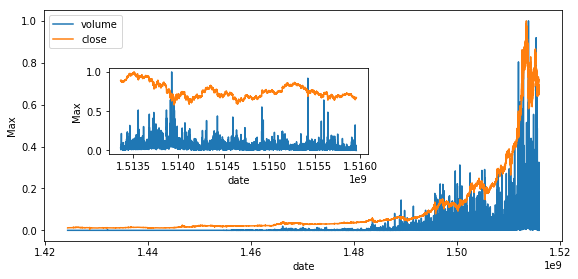

In [29]:
multiPlot(btc300, 'date', ('volume','close'), 12*24)

#### View data at daily intervals

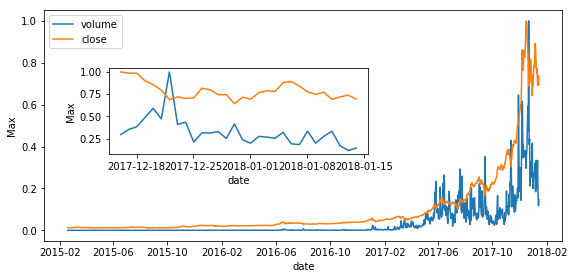

In [30]:
# View Data daily
multiPlot(btc86400, 'date', ('volume','close'), 1)

#### Lets look at the last 30 days since new years as japanese candle sticks using a package

C:\Users\Sebastien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


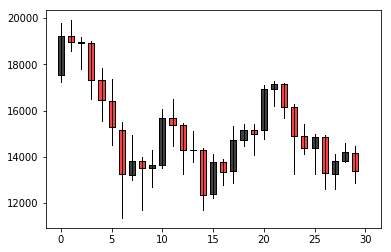

In [31]:
from matplotlib.finance import candlestick2_ohlc
fig, ax = plt.subplots()
candlestick2_ohlc(ax,btc86400['open'][-30:],btc86400['high'][-30:],btc86400['low'][-30:],btc86400['close'][-30:],width=0.6)
fig

### Google Trends data

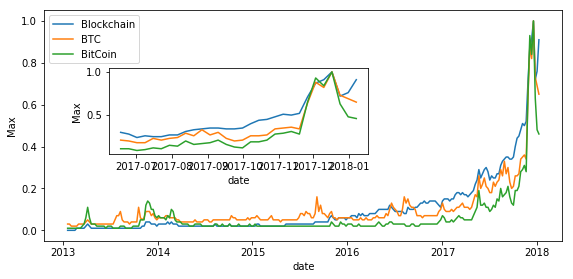

In [33]:
multiPlot(trends, 'date', terms, 1)

In [34]:
terms

('Blockchain', 'BTC', 'BitCoin')

## 1.6 Data consistency checking
* As said and solved above, we weekly trends needed to be matched to the daily price data we chose to follow.
* The data set contains no missing values
* As the trends are weekly, the most recent days will rarely have a trend as they are still being calculated for the current week. Therefore we chose to use the data from the start of poloniex exchange prices to the end of 2017.

# Part 2: Estimation question
* So here as we said before we want to see how we can predict the closing price of a day according to google trends.

* Let's start with a simple fitting method:

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

We import the data fresh, delete the unnecessary column and transform the date as a new index for our dataframe

In [71]:
file = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname('data.csv')))
file_name = 'data'
# Mac
data = pd.read_csv(file+'/'+file_name+'.csv')
# Windows
#data = pd.read_csv(file+'\\'+file_name+'.csv')

del data['Unnamed: 0']
data.set_index('date', inplace = True)

## 2.1 A look at the relationship between close price and all other variables

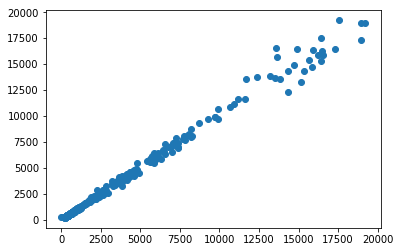

In [37]:
plt.scatter(data["open"],data["close"])
plt.show()

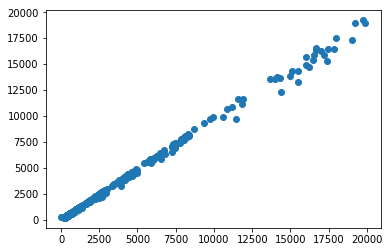

In [38]:
plt.scatter(data["high"],data["close"])
plt.show()

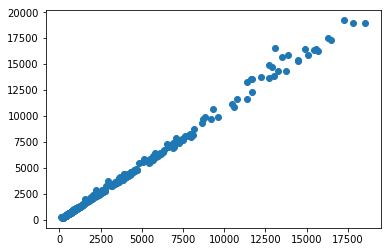

In [39]:
plt.scatter(data["low"],data["close"])
plt.show()

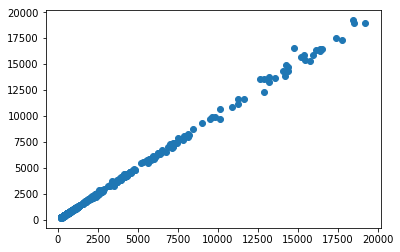

In [40]:
plt.scatter(data["weightedAverage"],data["close"])
plt.show()

### Remark:
Up to here we have very correlated data. One might think that this is amazing and it will be very easy to predict closing price! But this correlation is actually normal: for example close price is defined as open price the day before. And most of these variables are directly calculated from each other. So that does not give much "interesting" information. A part maybe from the fact that price in general does not move a lot from one day to another (if compared to the whole price evolution).

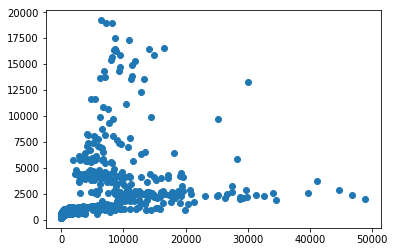

In [41]:
plt.scatter(data["quoteVolume"],data["close"])
plt.show()

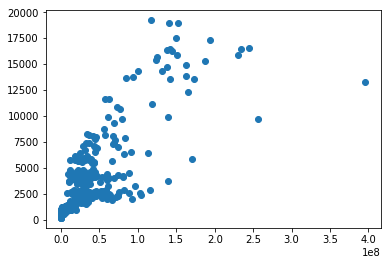

In [42]:
plt.scatter(data["volume"],data["close"])
plt.show()

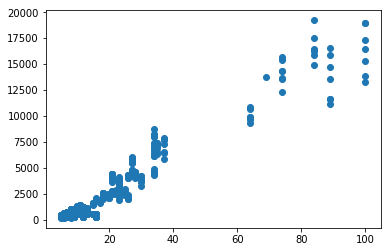

In [43]:
plt.scatter(data["tBTC"],data["close"])
plt.show()

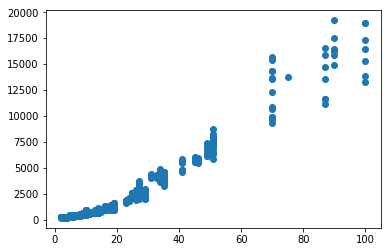

In [44]:
plt.scatter(data["tBlockchain"],data["close"])
plt.show()

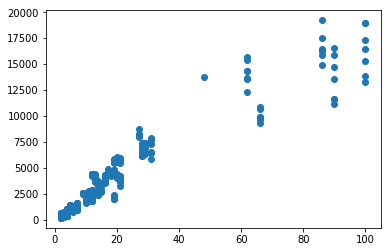

In [45]:
plt.scatter(data["tBitCoin"],data["close"])
plt.show()

#### Here we see that the graph of close price vs tBlockchain seem to look like a polynomial function. Perhaps of degree 3?
Let's try to make our data "fit" a polynomial function and see which function estimates our price with the least errors. For that we will define polynomial functions and find the parameters minimizing the least square errors thanks to scipy.optimize.

## 2.2 First try with a degree 3 polynomial function.

#### Let's define these functions:

In [46]:
def polynomial_model(param, x): ### Polynome of degree 3
    return param[0] + param[1]*x + param[2]*x**2 + param[3]*x**3

def polynomial_err(param, x, y):
    return y - polynomial_model(param, x)

#### Here we generate the minimization algorithm. Param1 is the set of coefficients of the polynomial function minimizing the least square error

In [47]:
x_data = data['tBlockchain']
y_data = data['close']

#### Initialisation of the iterations

In [48]:
param0 = [1, 1, 1, 1] 

param1, meta_res = scipy.optimize.leastsq(polynomial_err, param0[:], args = (x_data, y_data))

#### Now let's plot our result

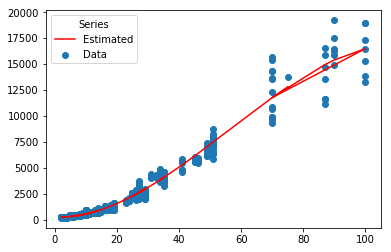

Initial parameters : [1, 1, 1, 1]
Estimated parameters : [  2.62381472e+02  -1.07468899e+01   4.30477307e+00  -2.57471800e-02]


In [49]:
y_model = polynomial_model(param1, x_data) 
plt.scatter(x_data,y_data,label='Data')
plt.plot(x_data,y_model,label='Estimated', color = 'Red')
plt.legend(loc='best', title='Series')
plt.show()

print("Initial parameters :", param0)
print("Estimated parameters :", param1)

#### We see that the estimation curve is "thick" due to unordered data. This issue can be solved with the following method:

In [50]:
data = data.sort_values('tBlockchain', ascending=True)

#### Relaunch the code with ordered data

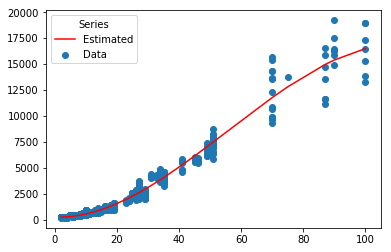

Initial parameters : [1, 1, 1, 1]
Estimated parameters : [  2.62381472e+02  -1.07468899e+01   4.30477307e+00  -2.57471800e-02]


In [51]:
x_data = data['tBlockchain'] 
y_data = data['close']   

param0 = [1, 1, 1, 1] ## Initialisation of the iterations

param1, meta_res = scipy.optimize.leastsq(polynomial_err, param0[:], args = (x_data, y_data))
#%%
y_model = polynomial_model(param1, x_data) 
plt.scatter(x_data,y_data,label='Data')
plt.plot(x_data,y_model,label='Estimated', color = 'Red')
plt.legend(loc='best', title='Series')
plt.show()

print("Initial parameters :", param0)
print("Estimated parameters :", param1)

#### Now: how to make sure that this polynome is the one that is the best predictor? What about degree 2? What about degree 4?
* Let's compare how good are different polynomes at predicting the closing price. For that we cannot measure the performance of each polynome by seeing how well they fit the training data: obviously, the higher the degree, the best "fit" (-> overfitting)

* So, in order to measure the performances of each polynome we will split the data into training and testing sets, and see how well each polynome fits the testing set (the part of the data not used to build the model).

#### To do so, we need to shuffle the data and separate the set in 70%/30% for example.¶

## 2.3 Cross Validation and different polynomes comparison

Let us define an additional function

In [109]:
# By default: 70% training and 30% testing
def shuff(data, ratio = 0.3):    
    data.reset_index(inplace = True)
    
    N = len(data)

    randomized_indices = np.arange(N)
    np.random.shuffle(randomized_indices)
 
    #dataset after index randomization
    shuffled_data = data.iloc[randomized_indices,:] 

    ### Split the dataset into two subsets ###

    ## Build training set ##
    training_data = shuffled_data[:int((1-ratio)*N)]

    ## Build testing set ##
    testing_data = shuffled_data[int((1-ratio)*N):]
    
    data.set_index('date', inplace = True)
    
    return training_data, testing_data

#### Let us use the function to split the data into a training and testing set

In [110]:
training_data, testing_data = shuff(data)

training_data = training_data.sort_values('tBlockchain', ascending=True)    
testing_data = testing_data.sort_values('tBlockchain', ascending=True)  

x_data = training_data['tBlockchain'] 
y_data = training_data['close']   

x_test = testing_data['tBlockchain'] 
y_test = testing_data['close']

#### Let us now define the functions we will use to create different polynomes, optimize them, and measure their performances:

* This function creates a polynome of degree n

In [111]:
def polynomialModelN(n, param, x): 
    temp = 0
    for i in range(n):
        temp = temp + param[i]*x**(i)
    return temp

* This function is defining the error between observed values and fitted values

In [112]:
def polynomialError(param, x, y): 
    return y - polynomialModelN(len(param), param, x)

* This function gives the mean square error

In [113]:
def meanSquareError(true, predicted): 
    delta = true - predicted
    return sum(delta**2)/len(delta)

* Here we create the function that plots and compares N polynomes in increasing degree order:


In [114]:
def magic(n, x_data = x_data, x_test = x_test, y_data = y_data, y_test = y_test):
    n = n+1
    param0 = np.ones(n)
    param1, meta_res = scipy.optimize.leastsq(polynomialError, param0[:], args = (x_data, y_data))
    
    plt.scatter(x_data,y_data,label='Training Data', color = '#EBA911')
    plt.scatter(x_test,y_test,label='Testing Data', color = '#0CC88F' )
    
    smooth_x = np.linspace(0,max(x_data),1000)   #### This is to make sure that our curve is "smooth"
    
    plt.plot(smooth_x,polynomialModelN(n, param1, smooth_x),label='Estimated', color = 'Red')
    plt.legend(loc='best', title='Series')
    plt.show()
    
    mseTrain = meanSquareError(y_data, polynomialModelN(n, param1, x_data))
    mseTest = meanSquareError(y_test, polynomialModelN(n, param1, x_test))
    
    return int(mseTrain), int(mseTest)

* Computing the training and testing error to compare them in a table and graphically

In [115]:
def trainTestError(n):
    error = []
    for i in range(n):
        error.append(magic(i+1))
    
    plt.plot(error)
    plt.xticks(list(range(0,n)),list(range(1,n+1)))
    plt.show()
    
    return error

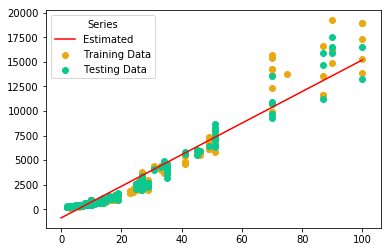

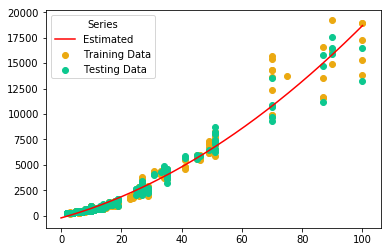

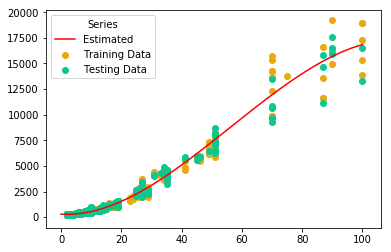

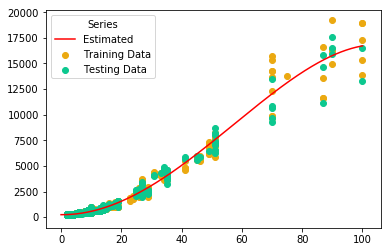

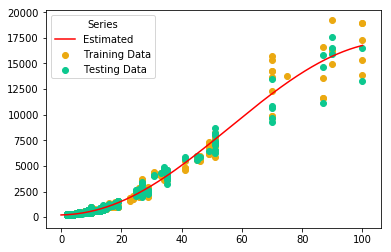

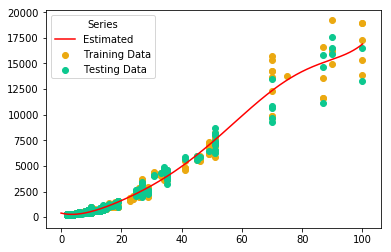

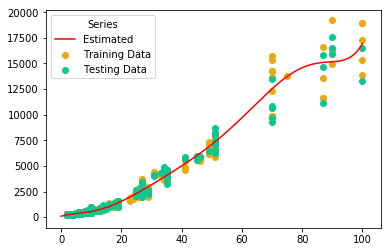

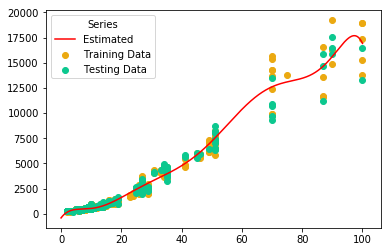

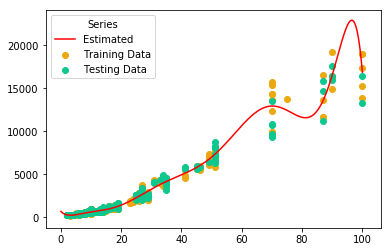

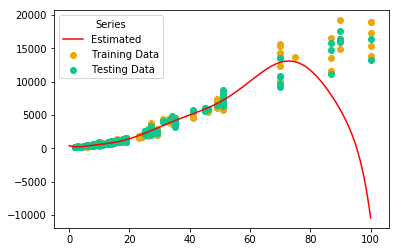

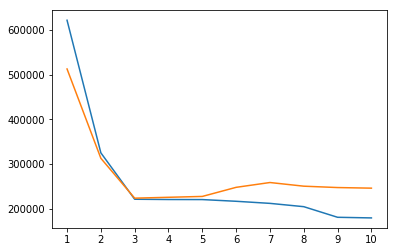

[(621915, 512860),
 (325076, 312895),
 (221232, 223633),
 (220614, 225593),
 (220477, 227518),
 (216655, 247879),
 (211987, 258654),
 (204581, 250459),
 (180829, 247391),
 (179422, 246032)]

In [116]:
trainTestError(10)

### What do we see here?
Most of the time, the polynome showing the lower error on the testing data set is of degree 3 (see orange curve). However this seem to depend quite a lot on the shuffle operation before splitting the set. An interesting idea would thus be to run a several simulations and take the average degree of the polynome best fitting the testing data. (In the fashion of a Monte-Carlo simulation)

We did not do it here unfortunately because we wanted to try different prediction methods instead, but this would be an interesting thing to develop.

### Another important remark:
Here we see that google research trends "jump" from a value to another, without being very "continuous". This is due to the fact that unfortunately we only have weekly data for Google Trends...

By having daily data we might have much more precise results. Indeed if we looks at the 2nd and 3rd week of December 2017, Bitcoin prices have increased and decreased a lot within the same week. Which ends up in high variability for closing price for a same "trend score". Making our model less predictable.

### Let us take a look at `'delta'` and `'logReturn'`

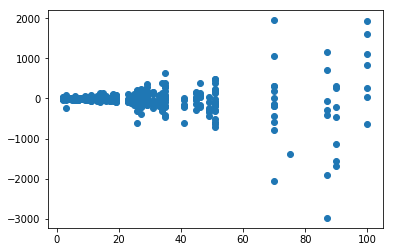

In [60]:
plt.scatter(data['tBlockchain'],data['delta'])
plt.show()

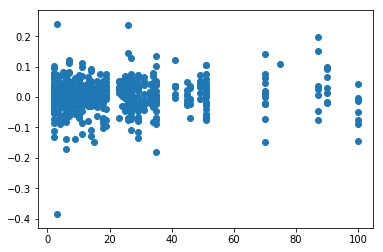

In [61]:
plt.scatter(data['tBlockchain'],data['logReturn'])
plt.show()

#### The `'logReturn'` plot seems to imply that the percentage price change from one day to the next has similar variance independent of the current `'Blockchain'` google trend.

# Part 3: As many other optional questions as you want
Until now, we have seen one simple prediction method where we try to predict one variable `'closing'` Price according to only one other variable `'tBlockchain'`.

Now let us see if we can predict closing price better by using other models taking into account a greater number of variables.

* How much variation does each model explain?

Next, how accurately can we predict whether the price goes up or down (binary) and by how much (continuous)? Using the `'delta'` variable
* Can we predict the log daily returns?

This will use the `'logReturn'` variable

In [ ]:
file = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname('data.csv')))
file_name = 'data'
# Mac
data = pd.read_csv(file+'/'+file_name+'.csv')
# Windows
#data = pd.read_csv(file+'\\'+file_name+'.csv')

del data['Unnamed: 0']
data.set_index('date', inplace = True)

## 3.1 Close price linear regression with several variables

#### The next step is to do multiple regressions and to compare them

First let us define functions with the additional use of the sklearn package

In [62]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def linReg(X, y, test_ratio = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio)
    
    lm = linear_model.LinearRegression()

    model = lm.fit(X_train, y_train)
    predictions = lm.predict(X_test)
    
    plt.scatter(y_test, predictions, color = '#EBA911')
    plt.show()
    
    print("R-Square: ", model.score(X_test, y_test))
    print("Mean Square Error: ", meanSquareError(y_test, predictions))
    
    return model

#### Predict close price using all available information that was not self generated through a function of close price

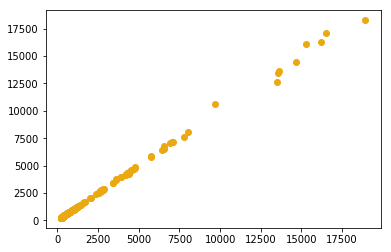

R-Square:  0.998393700844
Mean Square Error:  16544.9159749


In [63]:
y = data['close']
X = data[data.columns.difference(['delta', 'close', 'logReturn'])]

test = linReg(X, y)

Here we see that we have a very high R-square score, but as we said before, this is "normal" considering that we are using variables which are very related to close price. (High, low, open: previous close, weightedAverage : function of close).

#### Predict close price: Additionally excluding open

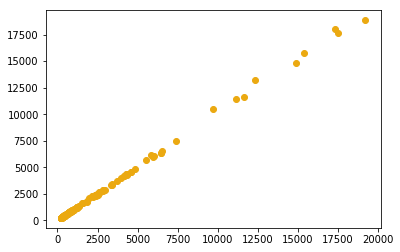

R-Square:  0.998673455499
Mean Square Error:  12763.592197


In [64]:
y = data['close']
X = data[data.columns.difference(['delta', 'close', 'open', 'logReturn'])]

test = linReg(X, y)

Same result practically.

#### Predict close price: Additionally excluding weightedAverage

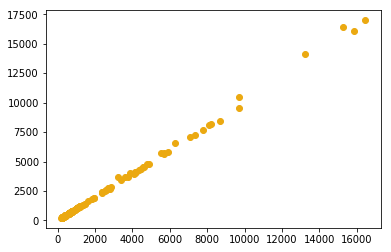

R-Square:  0.99763231408
Mean Square Error:  17090.9227266


In [65]:
y = data['close']
X = data[data.columns.difference(['delta', 'close', 'open', 'weightedAverage', 'logReturn'])]

test = linReg(X, y)

Same result practically.

#### Predict close price: Additionally excluding high, low (all data highly correlated to historical price)

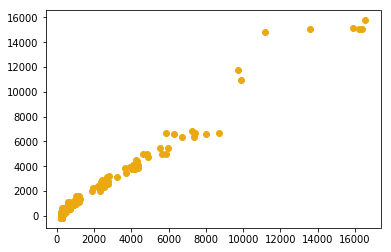

R-Square:  0.974485722262
Mean Square Error:  231628.30299


In [66]:
y = data['close']
X = data[data.columns.difference(['delta', 'close', 'open', 'weightedAverage', 'high', 'low', 'logReturn'])]

test = linReg(X, y)

In this regression model we only estimate the price thanks to the `'Volume'`, `'QuoteVolume'`, and the three Google Trends.

The estimation is still surprisingly precise though (R-square = 97%)!

#### Predict close price only using google trends

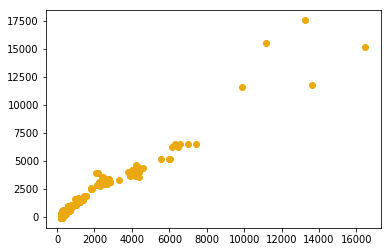

R-Square:  0.938517073963
Mean Square Error:  342073.590151


In [67]:
y = data['close']
X = data[['tBitCoin', 'tBTC','tBlockchain']]

test = linReg(X, y)

Finally in this regression model we use only `'tBTC'`,`'tBitCoin'`, and `'tBlockchain'`.
#### While the shape is not completely linear here (maybe a degree 3 polynome instead), the R square score is surprisingly high! It seems like it is rather possible to predict price only using Google Trends this way.

### Preliminary conclusion:
It seems possible to predict rather well historical prices from Google Trends using simple linear methods.

However, this is when we are taking a very large scale of time, and for "long term returns".

Now, let us imagine that we want to give day-to-day recommendation to an investor willing to have direct return on investment (within one day), and so be able to see if tomorrow's price will increase of decrease.

For that let us first focus on `'delta'`.

### Let us try to predict the delta instead

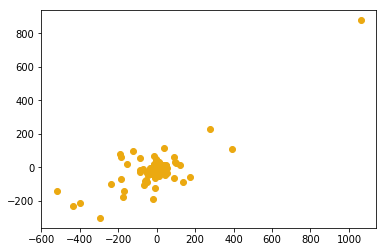

R-Square:  0.643001130086
Mean Square Error:  4270.65248571


In [68]:
y = data['delta']
X = data[data.columns.difference(['delta', 'close', 'open', 'logReturn'])]

test = linReg(X, y)

We see that trying to do a linear regression for estimating delta, scores pretty poorly.

Let us focus on more interesting information for investors: "To which extend in % will my investment increase tomorrow if I invest today." Indeed, changes for very low prices and changes for very high prices are not really comparable with delta.

### Let us look at the the logarithmic returns then

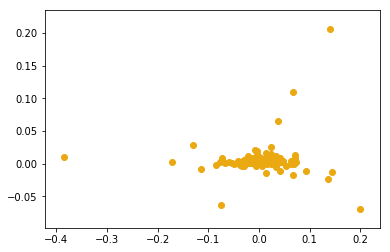

R-Square:  -0.0848432325069
Mean Square Error:  0.0023976765999


In [72]:
y = data['logReturn'][1:]
X = data[data.columns.difference(['delta', 'close', 'open', 'logReturn'])][1:]

test = linReg(X, y)

Predicting the change in price seems to be difficult at the true vs predicted plot appears closer to a random cloud than a diagonal line perfectly matching true and predicted values.

### Preliminary conclusion: predicting day-to-day % in increase or decrease of price seems rather not possible with our data.

### Is it then at least possible to know if tomorrow's price will increase of decrease? (Without any information on "how much?")

## 3.2 Logistic Regression: Predict price increase or decrease

For that, instead of using a regression method, we will use a classification method. Since we only have to categories (increase or decrease), a logistic regression classifier might be a good idea to try to predict the behavior of the price.

A way to measure the performance of a classifier is by doing and ROC curve of it's performance. For that we need to import the adequate package from sklearn, and we need to define a function that will plot the ROC as well as showing the confusion matric of our logistic classifier.

In [73]:
from sklearn.metrics import roc_curve, auc

def logReg(X, y, test_ratio = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    # This function comes from the package sklearn
    logm = linear_model.LogisticRegression()
    
    model = logm.fit(X_train, y_train)
    predictions = logm.predict(X_test)
    
    # This comes from sklearn.metrics
    fpr, tpr, _ = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    print("Confusion Matrix:") 
    print(confusion_matrix(y_test, predictions))
    print("Model Score: ", model.score(X_test, y_test))
    
    return model

We create our two categories: increase = 1, stricly decreasing = 0, and we apply the function to the new dataset.

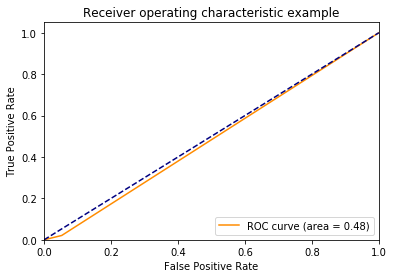

Confusion Matrix:
[[108   6]
 [ 94   2]]
Model Score:  0.52380952381


In [74]:
y = np.sign(data['delta'])
y = [1 if y>=0 else 0 for y in y]
X = data[data.columns.difference(['delta', 'close', 'open', 'logReturn'])]

test = logReg(X, y)

It seems that our model is marginally better than a coin flip, from the previous regressions the predicted and actual values seems to be random. The variations in delta look similar to a random walk with a few outliers. 

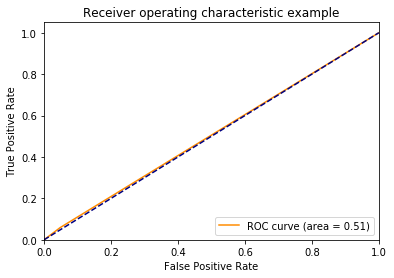

Confusion Matrix:
[[119   6]
 [ 80   5]]
Model Score:  0.590476190476


In [75]:
y = np.sign(data['delta'])
y = [1 if y>=0 else 0 for y in y]
X = data[data.columns.difference(['delta', 'close', 'open', 'logReturn', 'high', 'low', 'quoteVolume', 'volume', 'weightedAverage'])]

test = logReg(X, y)

The model barely performs better with the additional information beyond the `'tBlockchain'` Google Trend

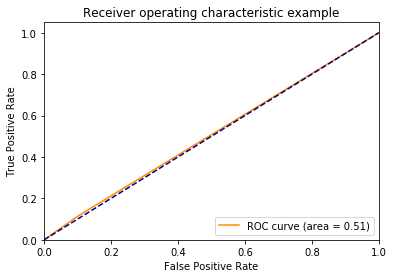

Confusion Matrix:
[[104  12]
 [ 83  11]]
Model Score:  0.547619047619


In [76]:
y = np.sign(data['delta'])
y = [1 if y>=0 else 0 for y in y]
X = data[data.columns.difference(['delta', 'close', 'logReturn', 'high', 'low', 'quoteVolume', 'volume', 'weightedAverage'])]

test = logReg(X, y)

The model based on opening price and the Blockchain trend performs a little better, but still rather poorly. 

### Preliminary conclusion: it seems rather hard to predict day-to-day increase of decrease in price with our data.

# Conclusion of the study

Through this study we have tried to link the evolution of Bitcoin historical prices to the amount of google searches on subjects directly related to itself: Bitcoin, BTC, and Blockchain.

We have seen that even with simple regression models it seems rather possible to predict Bitcoin prices thanks to Google trends. Our regressions models, starting by polynomial functions of `'tBlockchain'`, and then multilinear regressions taking into account more variables, had indeed high R-square scores. This means they could explain to a high-level the degree of variability in the evolution of Bitcoin price.

So a conclusion could be that, yes, it is indeed possible to predict the evolution of Bitcoin prices on the long-run. (Considering that future behaviors follows similar behaviors than the past)

However, whenever we tried to predict much more "short-term" data: such as the `'logarithmic return'` or simply the evolution of price from one day to another with `'delta'`, our models scored very poorly.
Two main reasons might explain that:
* First, the fact that we only had weekly data for Google Trends might not have "captured" the whole variability of such data, and thus it became impossible to predict daily variability with our models.
* Second, such data are too random on the short term, and/or are affected by factors we might have not discovered (with other sources of data). More models and data sources could be necessary to successfully capture the short term price fluctuations.